In [1]:
# mounts Google Drive to the Colab VM
from google.colab import drive, files
drive.mount('/content/drive')

# project github foldername
FOLDERNAME = '/content/drive/My Drive/CS231N/Project/RainfallNowcasting/Radar/'

# load python files from foldername
import sys
sys.path.append(FOLDERNAME)

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import datetime
import pandas as pd
import xarray as xr

# import plot_data
import data_preprocessing

import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import colors
%matplotlib inline
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 3

!sudo apt-get install libeccodes0

!pip install cfgrib
!pip install netcdf4

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libeccodes0 is already the newest version (2.6.0-2).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


In [0]:
# !!! ONLY LOAD DATA THAT ARE FOLLOWING EACH OTHER IN TIME !!!

zone = "NW"    # NW
years = [2018]    # 2016, 2017 or 2018
months = [6]
part_months = [2] # Choice between 1,2,3, as we said earlier each month is divided in 3 parts
new_size = [64,64] # None if you want to keep initial size
directory = '/content/drive/My Drive/CS231N/Project/RainfallNowcasting/Radar/MeteoNet/'
input_timeframes = 10 # Choose how many timeframes you want for the input
output_timeframes = 5 # Choose how many timeframes you want for the output
overlapping_data = 0 # Choose if you want the data to overlap (= 1) or not (= 0)
motion_content_data = 1 # Choose if your input data are for MCNet (= 1) or ConvLSTM (= 0)
motion_difference = 1 # Choose if the motion is the difference between 2 timesteps or not
normalization_min = 0 # Choose between -1 and 0, the max is always 1
percentage_test = 0.1  # Choose percentage of data to put in test data
rainfall_threshold_value = 80 # Value above which values are considered to be one


# Additional features

# Reflectivity
reflectivity_bool = 0
reflectivity_position = 1
reflectivity_max_threshold_value = 60 

# Rainfall quality
rainfall_quality_bool = 0
rainfall_quality_position = 1

# Masks
lsm_bool = 0 # Include Land/sea mask (= 1) or not (= 0)
lsm_position = 1 # Add the lsm mask as another channel in each input (= 1) or keep it separate (= 0)
elevation_bool = 0 # Include Land/sea mask (= 1) or not (= 0)
elevation_position = 1  # Add the lsm mask as another channel in each input (= 1) or keep it separate (= 0)

#Weather models
model = 'arpege' # 'arome' or 'arpege'
temperature_bool = 1
temperature_position = 1
temperature_max_threshold_value = 313
temperature_min_threshold_value = 263
dew_point_temperature_bool = 1
dew_point_temperature_position = 1
dew_point_temperature_max_threshold_value = 313
dew_point_temperature_min_threshold_value = 263
humidity_bool = 1
humidity_position = 1
wind_speed_bool = 1
wind_speed_position = 1
wind_speed_max_threshold = 35
wind_direction_bool = 1
wind_direction_position = 1
wind_components_bool = 1
wind_components_position = 1
pressure_bool = 1
pressure_position = 1
pressure_max_threshold = 105000
pressure_min_threshold = 96000
precipitation_bool = 1
precipitation_position = 1
weather_model_bool = {'temperature': temperature_bool, 'dew point temperature' : dew_point_temperature_bool,
                 'humidity': humidity_bool, 'wind speed': wind_speed_bool, 'wind directions': wind_direction_bool,
                 'wind components': wind_components_bool, 'pressure': pressure_bool,
                 'precipitation': precipitation_bool}
weather_model_position = {'temperature': temperature_position, 'dew point temperature' : dew_point_temperature_position,
                 'humidity': humidity_position, 'wind speed': wind_speed_position, 'wind directions': wind_direction_position,
                 'wind components': wind_components_position, 'pressure': pressure_position,
                 'precipitation': precipitation_position}
weather_model_max_threshold = {'temperature': temperature_max_threshold_value, 'dew point temperature' : dew_point_temperature_max_threshold_value,
                 'humidity': 100, 'wind speed': wind_speed_max_threshold, 'wind directions': 360,
                 'wind components': wind_speed_max_threshold, 'pressure': pressure_max_threshold,
                 'precipitation': rainfall_threshold_value}
weather_model_min_threshold = {'temperature': temperature_min_threshold_value, 'dew point temperature' : dew_point_temperature_min_threshold_value,
                 'humidity': 0, 'wind speed': 0, 'wind directions': 0,
                 'wind components': -wind_speed_max_threshold, 'pressure': pressure_min_threshold,
                 'precipitation': 0}
                


features_bool = {'reflectivity': reflectivity_bool, 'rainfall quality': rainfall_quality_bool,
                 'land sea': lsm_bool, 'elevation': elevation_bool}
features_position = {'reflectivity': reflectivity_position, 'rainfall quality': rainfall_quality_position,
                 'land sea': lsm_position, 'elevation': elevation_position}
features_max_threshold = {'reflectivity': reflectivity_max_threshold_value, 
                          'rainfall quality': 100, 'land sea': 1, 
                          'elevation': 629}
features_min_threshold = {'reflectivity': 0, 
                          'rainfall quality': 0, 'land sea': 0, 
                          'elevation': 0}



In [33]:
# Getting data and features 

X, y, features_dict = data_preprocessing.get_data_and_features(directory, zone, years, months, part_months, new_size,
                          input_timeframes, output_timeframes, overlapping_data,
                          normalization_min, percentage_test,
                          rainfall_threshold_value, 
                          features_bool, weather_model_bool, model,
                          weather_model_max_threshold, weather_model_min_threshold,
                          features_max_threshold, features_min_threshold)
print(X.shape)
print(y.shape)
print(features_dict.keys())

Year: 2018 Month: 6 Part of the month: 2, Done !
Got rainfall
2018-06-11 00:00:00
2018-06-12 00:00:00
2018-06-13 00:00:00
2018-06-14T00:00:00.000000000
(25,)
2018-06-14 00:00:00
2018-06-15 00:00:00
2018-06-16 00:00:00
2018-06-17 00:00:00
2018-06-18 00:00:00
2018-06-19 00:00:00
2018-06-20 00:00:00
2m
2018-06-11 00:00:00
2018-06-12 00:00:00
2018-06-13 00:00:00
2018-06-14T00:00:00.000000000
(25,)
2018-06-14 00:00:00
2018-06-15 00:00:00
2018-06-16 00:00:00
2018-06-17 00:00:00
2018-06-18 00:00:00
2018-06-19 00:00:00
2018-06-20 00:00:00
10m
2018-06-11 00:00:00
2018-06-12 00:00:00
2018-06-13 00:00:00
2018-06-14T00:00:00.000000000
(25,)
2018-06-14 00:00:00
2018-06-15 00:00:00
2018-06-16 00:00:00
2018-06-17 00:00:00
2018-06-18 00:00:00
2018-06-19 00:00:00
2018-06-20 00:00:00
P_sea_level
2018-06-11 00:00:00
2018-06-12 00:00:00
2018-06-13 00:00:00
2018-06-14T00:00:00.000000000
(24,)
2018-06-14 00:00:00
2018-06-15 00:00:00
2018-06-16 00:00:00
2018-06-17 00:00:00
2018-06-18 00:00:00
2018-06-19 00:0

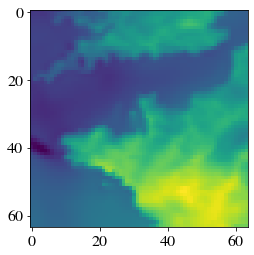

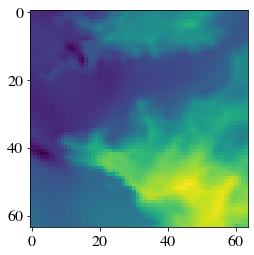

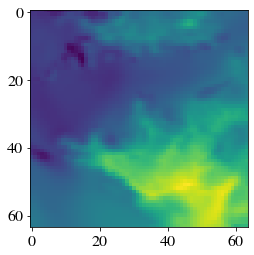

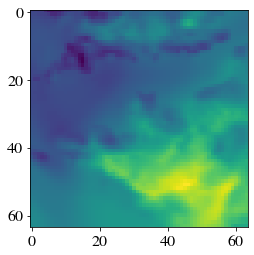

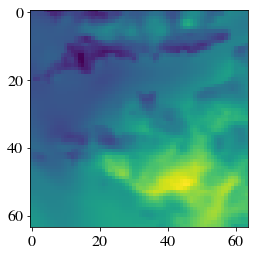

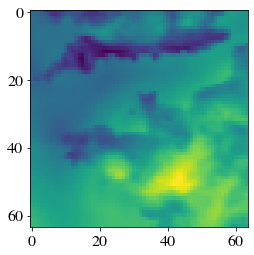

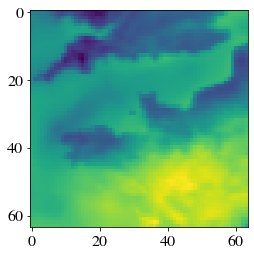

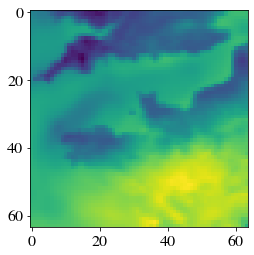

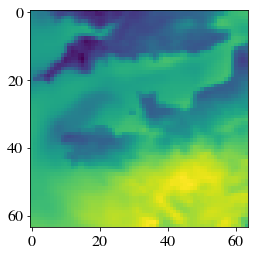

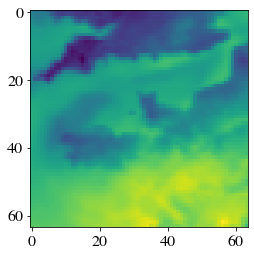

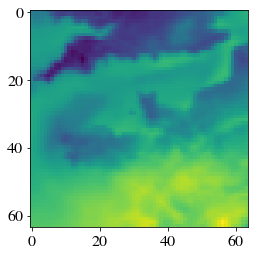

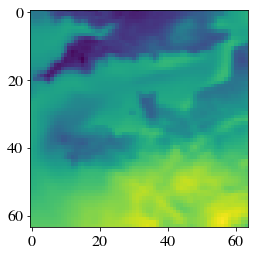

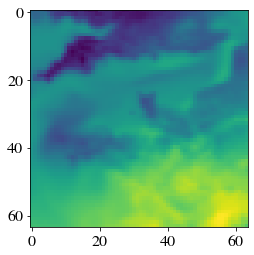

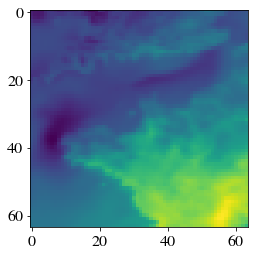

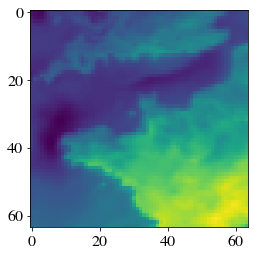

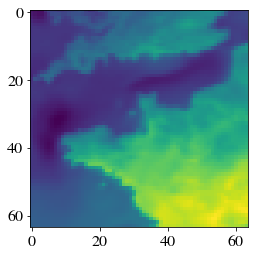

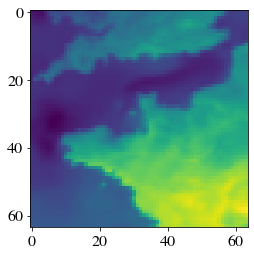

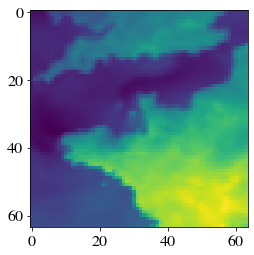

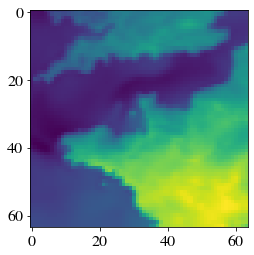

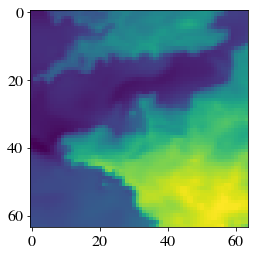

In [12]:
for i in range(20):
  plt.imshow(features_dict['temperature'][90 + i, 5, :, :,0])
  plt.show()

In [0]:
# Adding the features as channels to X
X = data_preprocessing.add_features_as_channels(X, features_dict, weather_model_position, features_position)

In [0]:
# Sort motion_content and get train-test
if motion_content_data == 0:
  X, y, X_test, y_test = data_preprocessing.split_train_test(percentage_test, motion_content_data, X, y, motion_difference)
  print(X.shape)
  print(y.shape)
  print(X_test.shape)
  print(y_test.shape)
  N, T, H, W, C = X.shape
else:
  X_motion, X_content, y, X_motion_test, X_content_test, y_test =  data_preprocessing.split_train_test(percentage_test, motion_content_data, X, y, motion_difference)
  print(X_motion.shape)
  print(X_content.shape)
  print(y.shape)
  print(X_motion_test.shape)
  print(X_content_test.shape)
  print(y_test.shape)
  N, T, H, W, C = X_motion.shape

(328, 9, 64, 64, 14)
(328, 64, 64, 14)
(328, 5, 64, 64, 1)
(36, 9, 64, 64, 14)
(328, 64, 64, 14)
(36, 5, 64, 64, 1)


In [0]:
# Custom metrics
def cor(y_gt, y_pred):
  return tfp.stats.correlation(y_gt, y_pred, sample_axis=None, event_axis=None)

In [0]:
kkk = 1
loss = 'logcosh'
optimizer = tf.keras.optimizers.Adam(lr=1e-4)
activ = 'relu'
init = 'he_normal'
nk = 128
ks = 5
lks = 3

In [0]:
# Our Model Architecture
def model_init(kkk, activ, init, nk, ks, lks, output_timeframes):
    inputs_motion = tf.keras.Input(shape=[None, H, W, C])
    inputs_content = tf.keras.Input(shape=[H, W, C])
    # Motion Encoder
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(nk, ks, padding='same', activation=activ, kernel_initializer=init))(inputs_motion)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D())(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(nk, ks, padding='same', activation=activ, kernel_initializer=init))(x)
    res = tf.keras.layers.Lambda(lambda x: x[:,-1])(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D())(x)
    x = tf.keras.layers.ConvLSTM2D(nk, ks, padding='same', activation=activ, kernel_initializer=init, return_sequences=True)(x)
    ME = tf.keras.layers.ConvLSTM2D(nk, ks, padding='same', activation=activ, kernel_initializer=init)(x)
    # Content Encoder
    x = tf.keras.layers.Conv2D(nk, ks, padding='same', activation=activ, kernel_initializer=init)(inputs_content)
    x = tf.keras.layers.Conv2D(nk, ks, padding='same', activation=activ, kernel_initializer=init)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(nk, ks, padding='same', activation=activ, kernel_initializer=init)(x)
    x = tf.keras.layers.Conv2D(nk, ks, padding='same', activation=activ, kernel_initializer=init)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    CE = tf.keras.layers.MaxPooling2D()(x)
    # Combination layers
    x = tf.keras.layers.Concatenate()([CE, ME])
    x = tf.keras.layers.Conv2D(nk, ks, padding='same', activation=activ, kernel_initializer=init)(x)
    x = tf.keras.layers.Conv2D(nk, ks, padding='same', activation=activ, kernel_initializer=init)(x)
    x = tf.keras.layers.Conv2D(nk, ks, padding='same', activation=activ, kernel_initializer=init)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    # Decoder layers
    x = tf.keras.layers.UpSampling2D()(x)
    x = tf.keras.layers.Conv2D(nk, ks, padding='same', activation=activ, kernel_initializer=init)(x)
    x = tf.keras.layers.Conv2D(nk, ks, padding='same', activation=activ, kernel_initializer=init)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Concatenate()([x, res])
    x = tf.keras.layers.UpSampling2D()(x)
    x = tf.keras.layers.Conv2D(nk, ks, padding='same', activation=activ, kernel_initializer=init)(x)
    x = tf.keras.layers.Conv2D(nk, ks, padding='same', activation=activ, kernel_initializer=init)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    # Prediction
    for i in range(output_timeframes-1):
      if i == 0:
        x = tf.stack([x, tf.zeros_like(x)], axis=1)
      else:
        x = tf.concat([x, tf.zeros_like(x[:, 0:1])], axis=1)
    x = tf.keras.layers.ConvLSTM2D(nk, ks, padding='same', activation=activ, kernel_initializer=init, return_sequences=True)(x)
    x = tf.keras.layers.ConvLSTM2D(nk, ks, padding='same', activation=activ, kernel_initializer=init, return_sequences=True)(x)
    preds = tf.keras.layers.Conv3D(1, lks, padding='same', activation='sigmoid',
                                   bias_initializer=tf.keras.initializers.Constant(value=-np.log(99)))(x)
    return tf.keras.Model(inputs=[inputs_motion, inputs_content], outputs=preds)

In [0]:

model = model_init(kkk, activ, init, nk, ks, lks, output_timeframes)
# Build optimizer
if normalization_min == 0:
  model.compile(optimizer=optimizer,
                loss=loss,
                metrics=['acc', cor, tf.keras.metrics.Precision(name='prec'),
                        tf.keras.metrics.Recall(name='recall')])
else:
  model.compile(optimizer=optimizer,
                loss=loss,
                metrics=['acc'])
# Fit the model
history = model.fit([X_motion, X_content], y, batch_size=5, epochs=1, validation_split=0.1)

59/59 [==============================] - 47s 800ms/step - loss: 0.0358 - acc: 0.7950 - cor: 0.5088 - prec: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0358 - val_acc: 0.8133 - val_cor: 0.0874 - val_prec: 0.0000e+00 - val_recall: 0.0000e+00


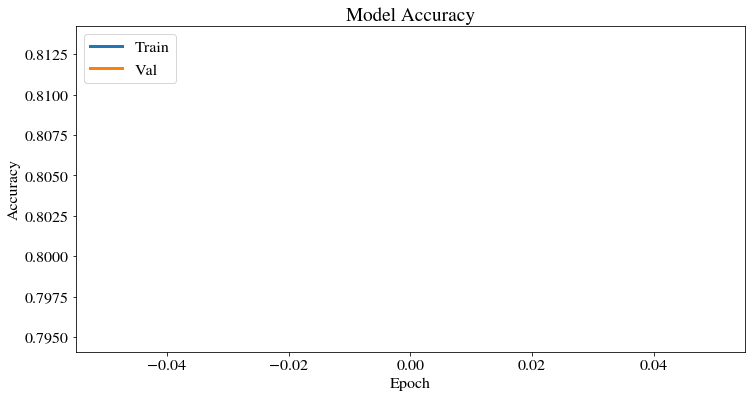

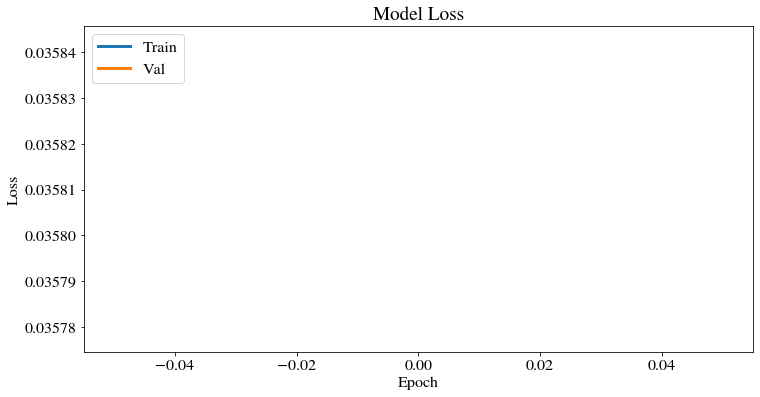

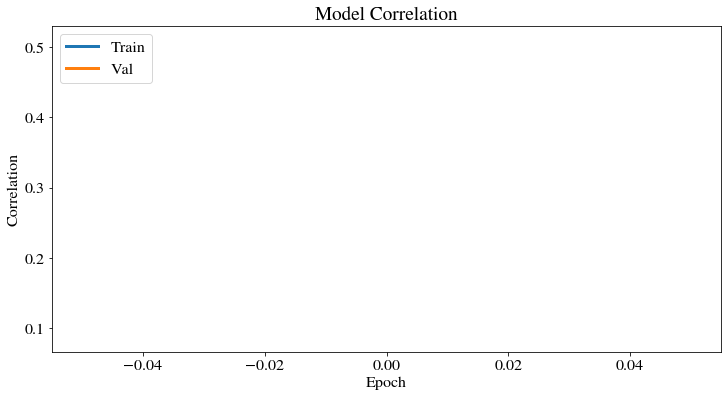

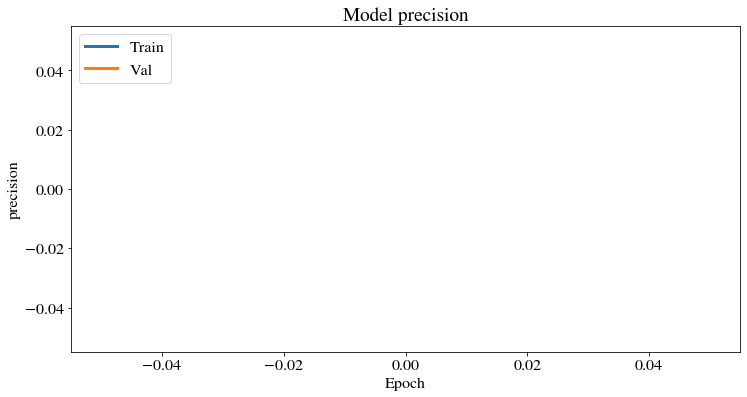

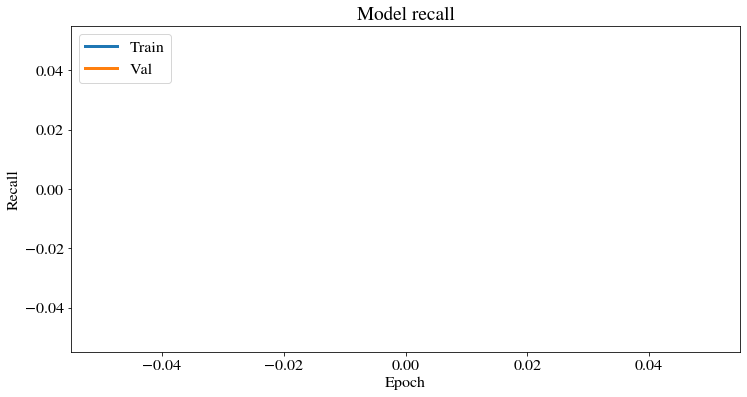

In [0]:
# Plot of loss, accuracy, cor, prec and recall
foldername = "/content/drive/My Drive/Results_project/"
plot_data.plot_history(history, normalization_min, save=False, foldername=foldername)

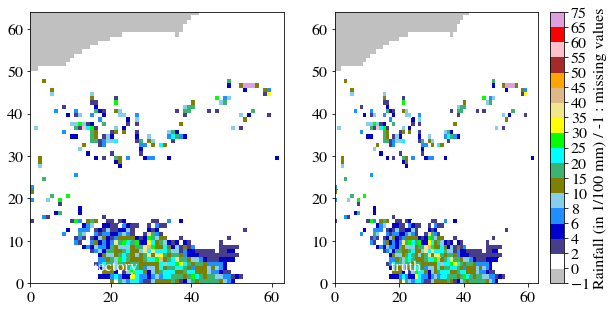

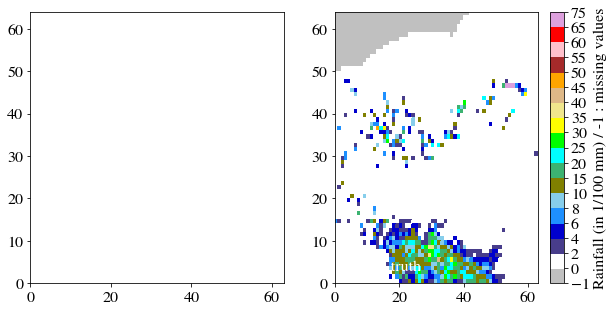

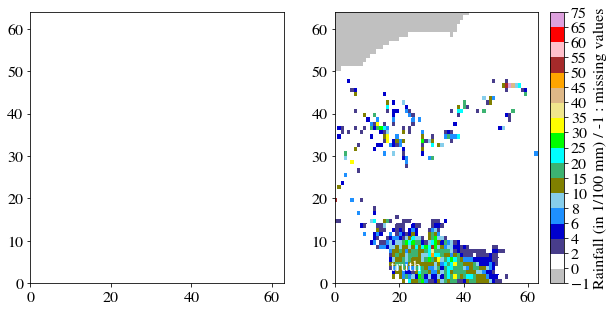

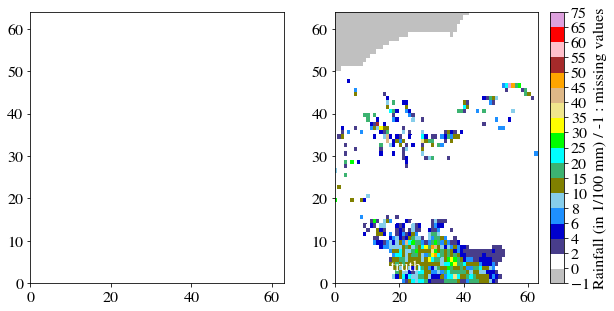

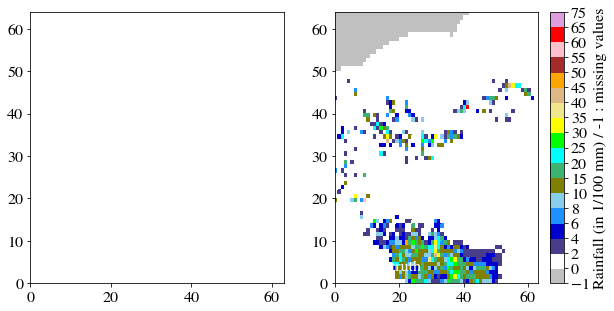

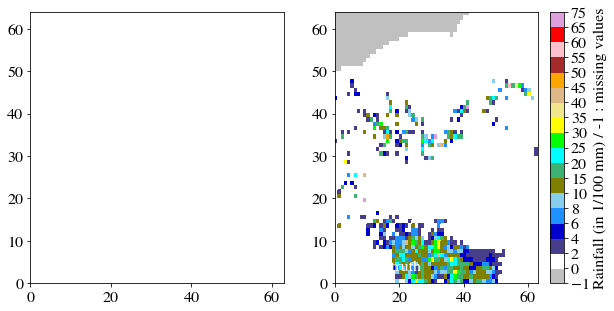

In [0]:
# Plot Train
if motion_content_data == 0:
  itest = 1
  track = X[itest, :, :, :, :]
  last_frame = X[itest, -1, :, :, :]
  track_y = y[itest, :, :, :, :]
  track = np.concatenate((last_frame[None, None,:,:,0:1], model.predict(track[None,:,:,:,:])), axis=1)
  true_track = np.concatenate((last_frame[None, :, :, 0:1], track_y), axis=0)
  plot_data.plot_track(true_track, track, normalization_min, 
                       rainfall_threshold_value, new_size, output_timeframes,
                       save=False, foldername='')
else:
  itest = 1
  track_content = X_content[itest]
  track_motion = X_motion[itest]
  track_y = y[itest, :, :, :, :]
  track = np.concatenate((track_content[None, None,:,:,0:1], model.predict([track_motion[None, :, :, :, :], track_content[None, :, :, :]])), axis=1)
  true_track = np.concatenate((track_content[None, :, :, 0:1], track_y), axis=0)
  plot_data.plot_track(true_track, track, normalization_min, 
                       rainfall_threshold_value, new_size, output_timeframes,
                       save=False, foldername='')
  

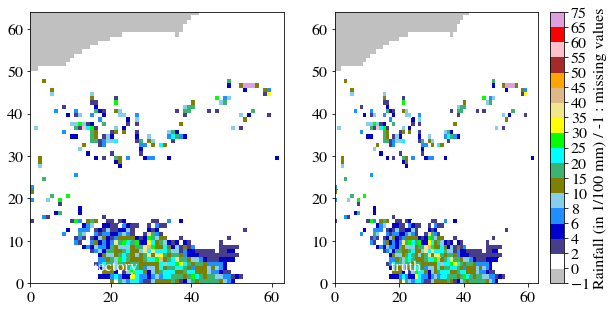

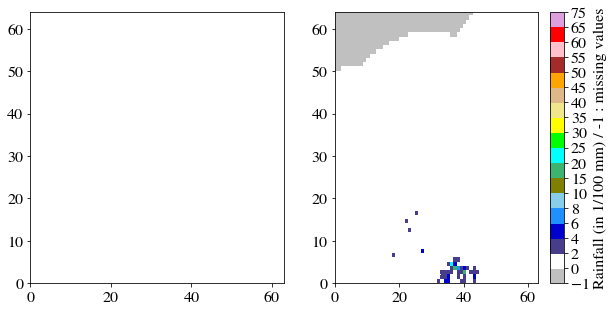

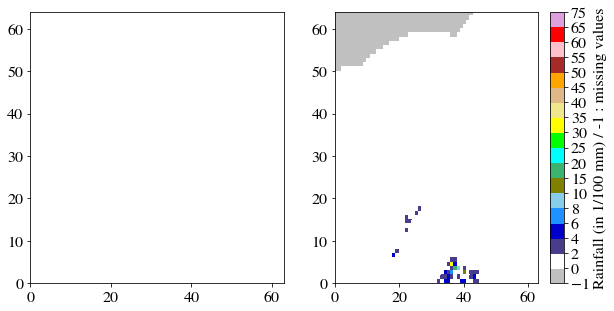

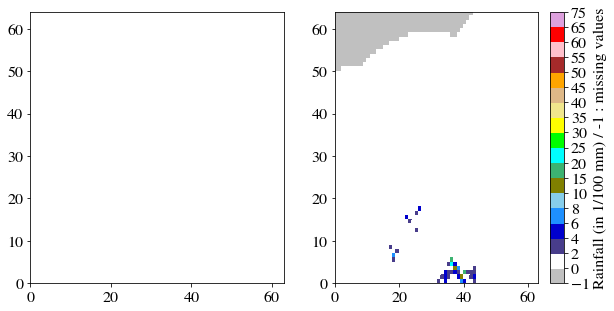

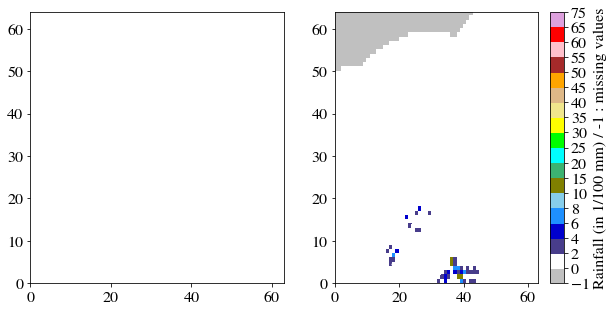

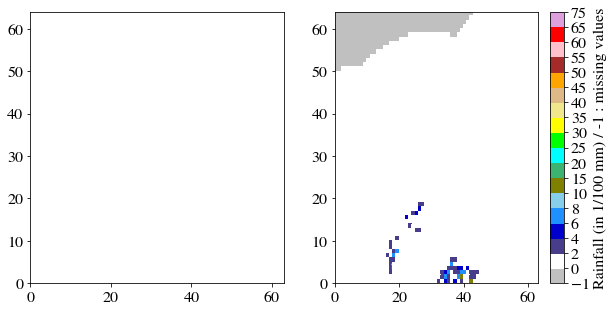

In [0]:
# Select a random observation, initial trajectory and predicted trajectory
# Plot Test
if motion_content_data == 0:
  itest = 1
  track = X_test[itest, :, :, :, :]
  last_frame = X_test[itest, -1, :, :, :]
  track_y = y_test[itest, :, :, :, :]
  track = np.concatenate((last_frame[None, None,:,:,0:1], model.predict(track[None,:,:,:,:])), axis=1)
  true_track = np.concatenate((last_frame[None, :, :, 0:1], track_y), axis=0)
  plot_data.plot_track(true_track, track, normalization_min, 
                       rainfall_threshold_value, new_size, output_timeframes,
                       save=False, foldername='')
else:
  itest = 1
  track_content = X_content_test[itest]
  track_motion = X_motion_test[itest]
  track_y = y_test[itest, :, :, :, :]
  track = np.concatenate((track_content[None, None,:,:,0:1], model.predict([track_motion[None, :, :, :, :], track_content[None, :, :, :]])), axis=1)
  true_track = np.concatenate((track_content[None, :, :, 0:1], track_y), axis=0)
  plot_data.plot_track(true_track, track, normalization_min, 
                       rainfall_threshold_value, new_size, output_timeframes,
                       save=False, foldername='')